# i. Introduction

## a. Background

In today's competitive business environment, efficient order management plays a pivotal role in ensuring customer satisfaction and cost optimization. A critical component of effective order management is the accurate daily forecasting of demand, which impacts inventory control, production planning, and resource allocation. This challenge is especially pronounced in industries characterized by dynamic and unpredictable demand, such as e-commerce and retail.

Historically, businesses have relied on simple forecasting techniques and historical data, but these methods often fall short in the face of modern market complexities. This data science project leverages advanced techniques to create robust demand forecasting models that adapt to changing market dynamics.

## b. Objective
The primary objective of this data science project is to develop a highly accurate and adaptable daily demand forecasting system for order management.

# ii. Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import joblib
import json

# iii. Data Loading

In [2]:
#Import data from GitHub
url = "https://raw.githubusercontent.com/fahmimnalfrzki/Dataset/main/Daily_Demand_Forecasting_Orders.csv"
df = pd.read_csv(url, delimiter=";")

In [3]:
#Create synthetic data functions to overcome data limitations
num_synthetic_samples = 1000

synthetic_data = []
for _ in range(num_synthetic_samples):
    synthetic_sample = df.sample(n=len(df), replace=True)
    synthetic_data.append(synthetic_sample)

sdf = pd.concat(synthetic_data)

In [4]:
#Rename columns that have long names
sdf.rename(columns={'Week of the month (first week, second, third, fourth or fifth week': 'Week of the month'}, inplace=True)
sdf.rename(columns={'Day of the week (Monday to Friday)': 'Day of the week'}, inplace=True)
sdf.rename(columns={'Target (Total orders)': 'Total orders'}, inplace=True)

# iv. Exploratory Data Analysis (EDA)

In [5]:
sdf.head(5)

,Week of the month,Day of the week,Non-urgent order,Urgent order,Order type A,Order type B,Order type C,Fiscal sector orders,Orders from the traffic controller sector,Banking orders (1),Banking orders (2),Banking orders (3),Total orders
41,2,3,165.472,102.530,46.295,96.870,124.837,0.000,48458.0,43112.0,72840,11304.0,268.002
25,2,4,148.139,85.310,35.576,79.997,123.253,5.377,59686.0,14188.0,67617,NaN,238.826
39,1,6,275.076,121.697,109.888,131.165,175.777,20.057,37906.0,138536.0,85378,14020.0,416.830
13,4,2,220.343,141.406,46.241,NaN,196.296,1.653,34878.0,NaN,117137,29188.0,363.402
0,1,4,316.307,223.270,61.543,175.586,302.448,0.000,65556.0,44914.0,188411,14793.0,539.577


There are 13 columns in the dataset provided.

In [6]:
sdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60000 entries, 41 to 24
Data columns (total 13 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Week of the month                          60000 non-null  int64  
 1   Day of the week                            60000 non-null  int64  
 2   Non-urgent order                           58966 non-null  float64
 3   Urgent order                               58104 non-null  float64
 4   Order type A                               57918 non-null  float64
 5   Order type B                               58972 non-null  float64
 6   Order type C                               58051 non-null  float64
 7   Fiscal sector orders                       58983 non-null  float64
 8   Orders from the traffic controller sector  57076 non-null  float64
 9   Banking orders (1)                         54990 non-null  float64
 10  Banking orders (2)      

The given dataset only contains 2 data types, namely int and float.

In [7]:
sdf.isnull().sum()

Week of the month                               0
Day of the week                                 0
Non-urgent order                             1034
Urgent order                                 1896
Order type A                                 2082
Order type B                                 1028
Order type C                                 1949
Fiscal sector orders                         1017
Orders from the traffic controller sector    2924
Banking orders (1)                           5010
Banking orders (2)                              0
Banking orders (3)                           4005
Total orders                                    0
dtype: int64

There are missing values in 70% of the given columns.

In [8]:
sdf.describe()

,Week of the month,Day of the week,Non-urgent order,Urgent order,Order type A,Order type B,Order type C,Fiscal sector orders,Orders from the traffic controller sector,Banking orders (1),Banking orders (2),Banking orders (3),Total orders
count,60000.000000,60000.000000,58966.000000,58104.000000,57918.000000,58972.000000,58051.000000,58983.000000,57076.000000,54990.000000,60000.000000,55995.000000,60000.000000
mean,3.026600,4.024850,173.690401,119.609193,52.266417,109.397833,139.682716,78.229866,44423.117265,47392.700800,79714.073117,21934.710831,301.199239
std,1.267472,1.391413,69.357338,26.998932,18.900263,50.892092,41.631348,185.205181,12202.467933,45893.948142,40172.595775,11394.513048,88.907291
min,1.000000,2.000000,43.651000,77.371000,21.826000,25.125000,74.372000,0.000000,11992.000000,6440.000000,16411.000000,7679.000000,129.412000
25%,2.000000,3.000000,126.030000,102.530000,39.600000,72.826000,112.724000,1.223000,35033.000000,19782.000000,50763.000000,12516.000000,238.826000
50%,3.000000,4.000000,151.341000,113.870000,47.331000,99.072000,125.868000,9.135000,43284.000000,32150.000000,67617.000000,16710.000000,289.657000
75%,4.000000,5.000000,196.555000,133.069000,58.378000,135.189000,162.044000,21.272000,52042.000000,45733.000000,101048.000000,30134.000000,336.872000
max,5.000000,6.000000,435.304000,223.270000,118.178000,267.342000,302.448000,865.000000,71772.000000,210508.000000,188411.000000,55445.000000,616.453000


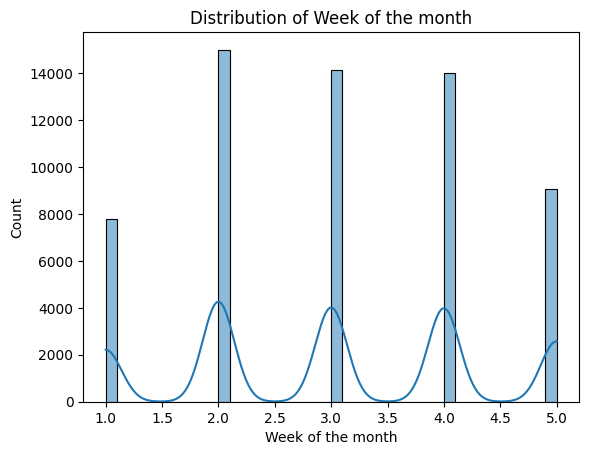

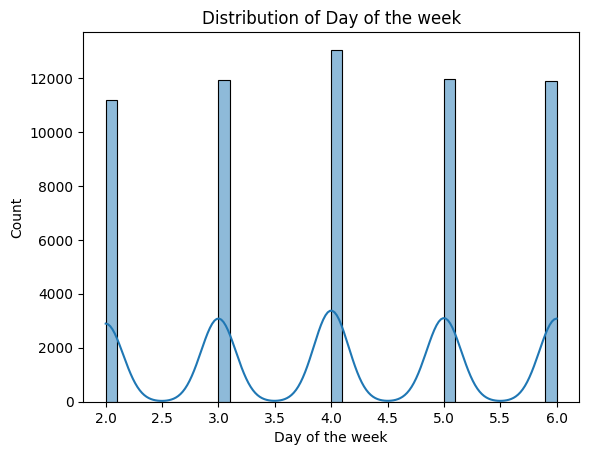

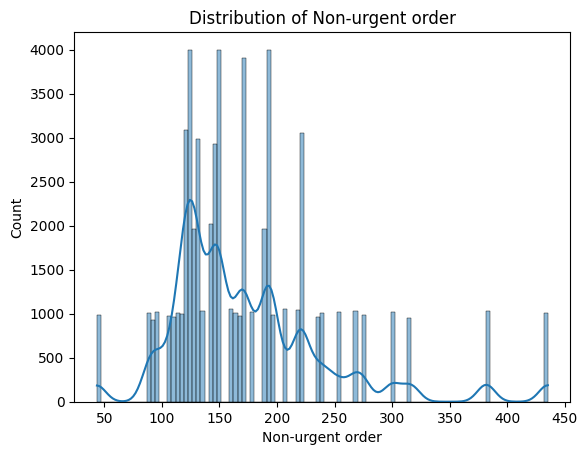

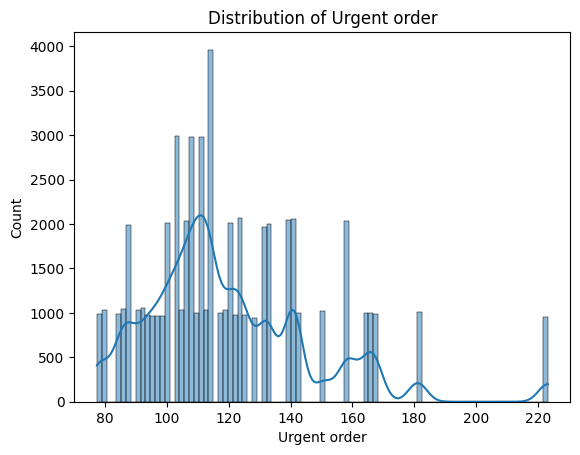

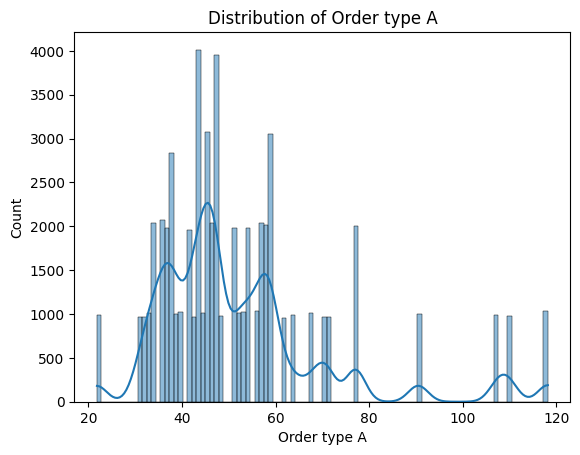

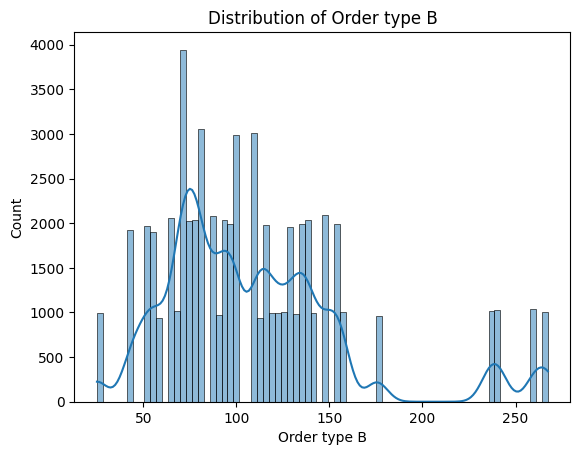

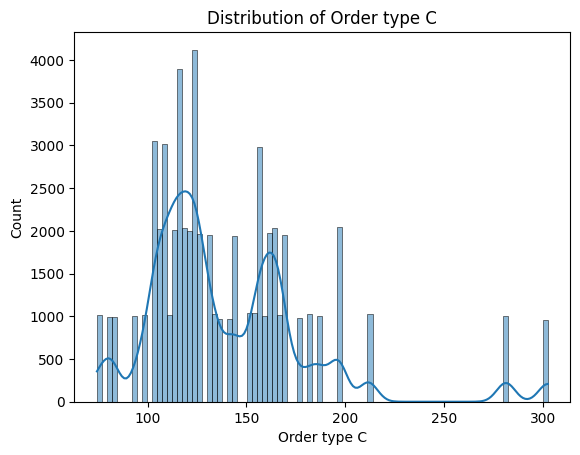

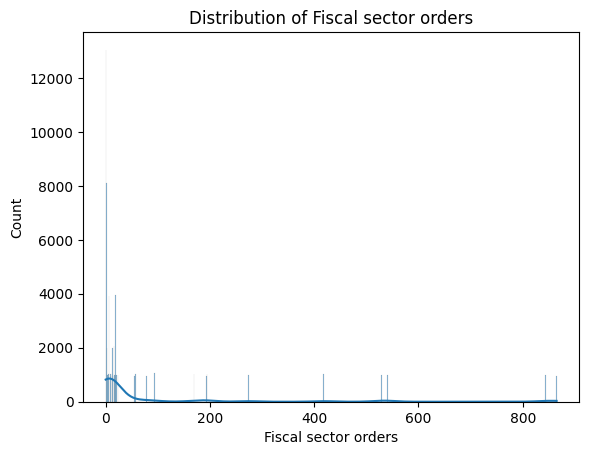

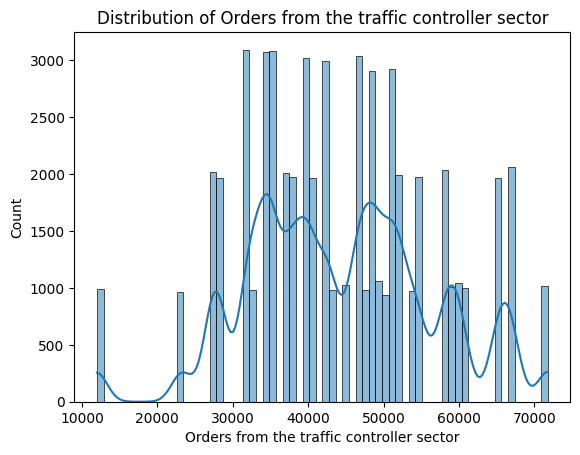

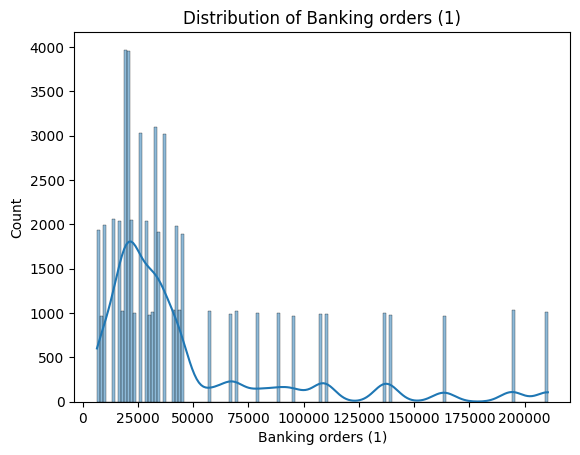

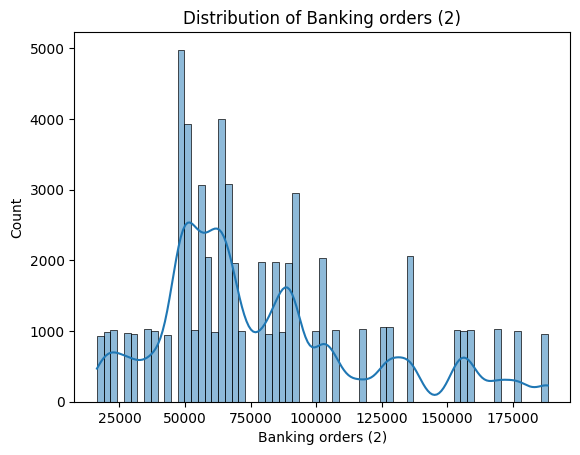

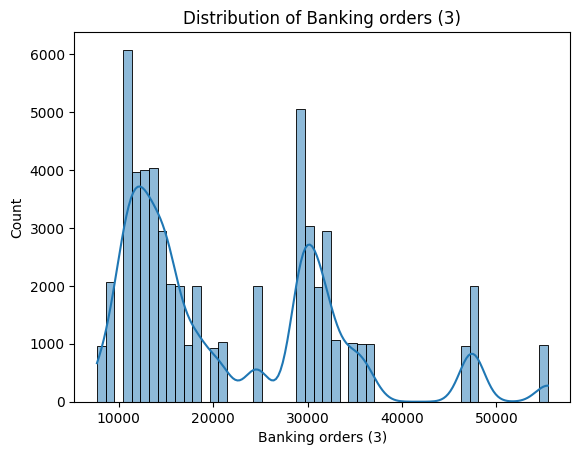

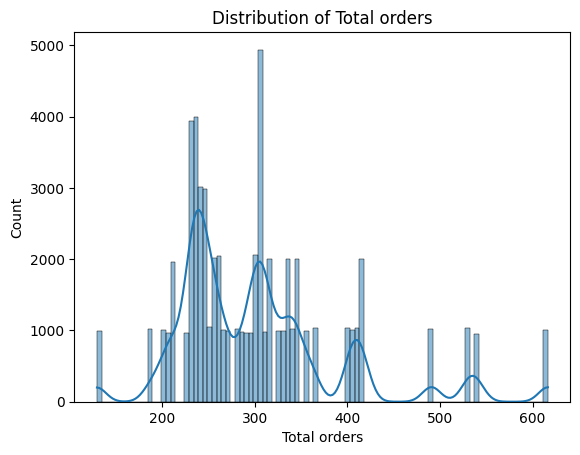

In [9]:
for column in sdf.select_dtypes(include=['float64', 'int64']).columns:
    sns.histplot(sdf[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.show()

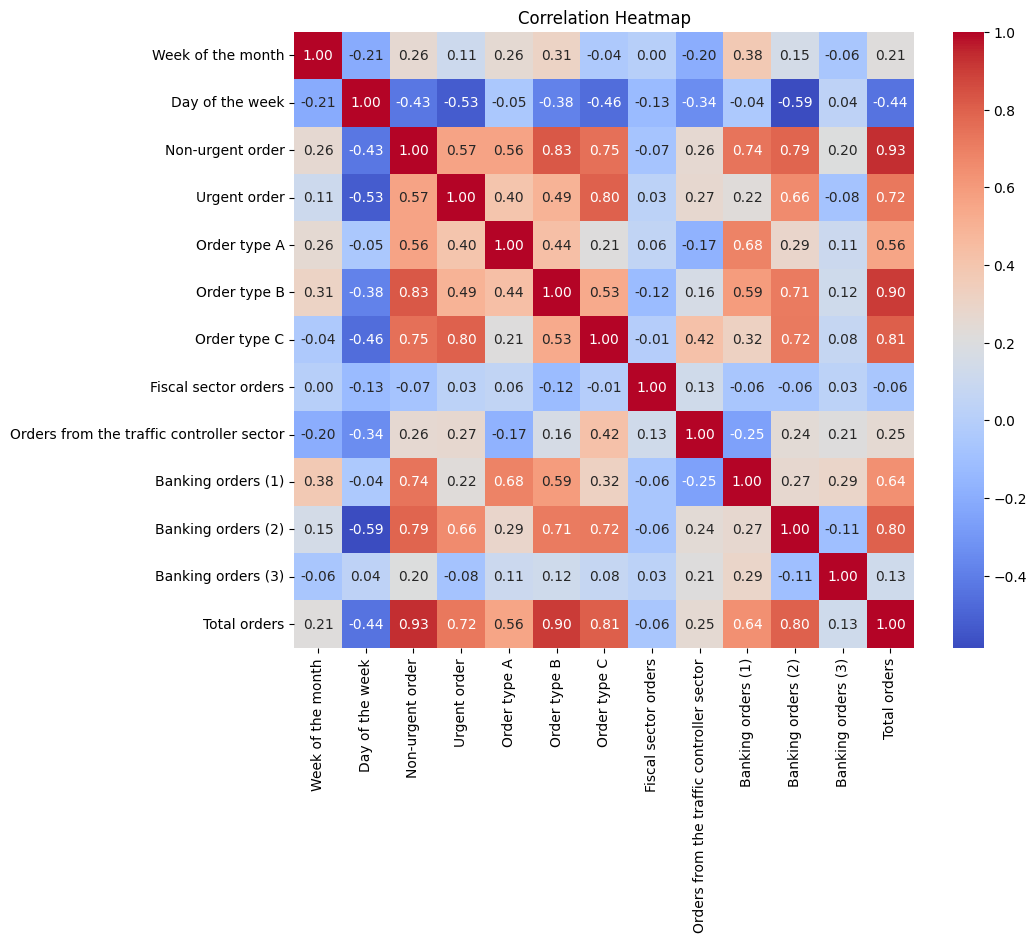

In [10]:
plt.figure(figsize=(10, 8))
sns.heatmap(sdf.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

The correlation between Non-urgent orders, Urgent orders, Order type B, Order type C, and Banking orders (2) with Total orders is very high, further analysis is needed.

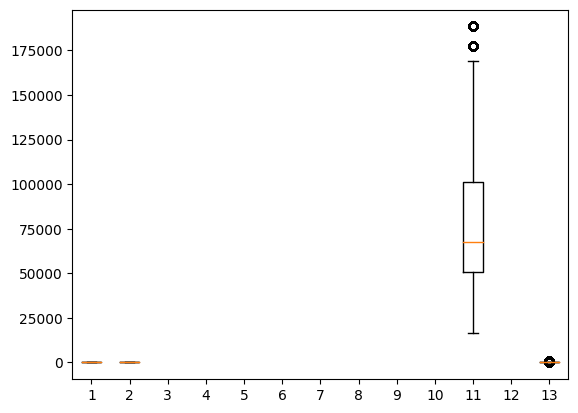

In [11]:
plt.boxplot(sdf)
plt.show()

There is a very large outlier in Banking orders (2).

# v. Feature Engineering

## a. Handling Missing Value

In [12]:
#Using iterative imputer
sdf_iterative = sdf.copy()
iterative_imputer = IterativeImputer(random_state=42)
sdf_iterative = iterative_imputer.fit_transform(sdf_iterative)
sdf_iterative = pd.DataFrame(sdf_iterative, columns=sdf.columns)

In [13]:
#Using knn imputer
sdf_knn = sdf.copy()
knn_imputer = KNNImputer()
sdf_knn = knn_imputer.fit_transform(sdf_knn)
sdf_knn = pd.DataFrame(sdf_knn, columns=sdf.columns)

## b. Data Splitting

In [14]:
#Using iterative imputer
X_iterative = sdf_iterative.drop(columns=["Total orders"])
y_iterative = sdf_iterative["Total orders"]
X_train_iterative, X_test_iterative, y_train_iterative, y_test_iterative = train_test_split(X_iterative, y_iterative, test_size=0.2, random_state=42)

In [15]:
#Using knn imputer
X_knn = sdf_knn.drop(columns=["Total orders"])
y_knn = sdf_knn["Total orders"]
X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(X_knn, y_knn, test_size=0.2, random_state=42)

# vi. Model Definition

Create a Regression model using Linear Regression.

# vii. Model Training

In [16]:
#Using iterative imputer
model_iterative = LinearRegression()
rfe_iterative = RFE(estimator=model_iterative, n_features_to_select=5)
rfe_iterative.fit(X_train_iterative, y_train_iterative)
feature_iterative = X_train_iterative.columns[rfe_iterative.support_]
model_iterative.fit(X_train_iterative[feature_iterative], y_train_iterative)
y_pred_iterative = model_iterative.predict(X_test_iterative[feature_iterative])

In [17]:
#Using knn imputer
model_knn = LinearRegression()
rfe_knn = RFE(estimator=model_knn, n_features_to_select=5)
rfe_knn.fit(X_train_knn, y_train_knn)
feature_knn = X_train_knn.columns[rfe_knn.support_]
model_knn.fit(X_train_knn[feature_knn], y_train_knn)
y_pred_knn = model_knn.predict(X_test_knn[feature_knn])

# viii. Model Evaluation

In [18]:
rmse_iterative = mean_squared_error(y_test_iterative, y_pred_iterative, squared=False)
rmse_knn = mean_squared_error(y_test_knn, y_pred_knn, squared=False)

print("RMSE (Iterative Imputer):", rmse_iterative)
print("RMSE (KNN Imputer):", rmse_knn)

RMSE (Iterative Imputer): 3.614033912593011e-07
RMSE (KNN Imputer): 5.820792782554729


Based on the RMSE results, the iterative imputer model is used as a prediction model because it has the smallest RMSE value.

In [19]:
y_train_pred = model_iterative.predict(X_train_iterative[feature_iterative])
y_test_pred = model_iterative.predict(X_test_iterative[feature_iterative])

mape_train = mean_absolute_percentage_error(y_train_iterative, y_train_pred) * 100
mape_test = mean_absolute_percentage_error(y_test_iterative, y_test_pred) * 100

print("MAPE on Training Data:", mape_train)
print("MAPE on Test Data:", mape_test)

MAPE on Training Data: 6.026855567007987e-08
MAPE on Test Data: 6.026190117005998e-08


Based on the MAPE results, it can be concluded that the model is fit due to the small difference between train and test data and also very good because the MAPE value is below 10%.

# ix. Model Saving

In [20]:
with open('model_iterative.pkl', 'wb') as file_1:
  joblib.dump(model_iterative, file_1)

# x. Conclusion

Based on EDA:

* There are 13 columns in the dataset provided.
* The given dataset only contains 2 data types, namely int and float.
* There are missing values in 70% of the given columns.
* The correlation between Non-urgent orders, Urgent orders, Order type B, Order type C, and Banking orders (2) with Total orders is very high, further analysis is needed.
* There is a very large outlier in Banking orders (2).

Based on ML evaluation:

* Based on the RMSE results, the iterative imputer model is used as a prediction model because it has the smallest RMSE value.
* Based on the MAPE results, it can be concluded that the model is fit due to the small difference between train and test data and also very good because the MAPE value is below 10%.